# Airbnb Price Prediction: Multi-Model Comparison

**Models**: OLS, Lasso, Random Forest, GBM, Histogram-based GBM

**Datasets**: Lisbon Q1 2025, Lisbon Q3 2025, Porto Q3 2025

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from time import time  # For tracking model training time
import matplotlib.pyplot as plt

# patsy: R-style formula interface for creating design matrices from data
from patsy import dmatrices

# sklearn.model_selection: K-fold cross-validation splitter
from sklearn.model_selection import KFold

# sklearn.linear_model: Lasso regression with L1 regularization
from sklearn.linear_model import Lasso, LassoCV

# sklearn.ensemble: Tree-based ensemble methods
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# sklearn.metrics: Error metrics for model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# statsmodels: Statistical modeling including OLS regression
import statsmodels.api as sm

## Data Preparation Function

In [2]:
def prepare_data(filepath):
    """
    1. Loading the data
    2. Excluding the target variable (price) and location variables from predictors
    3. Creating design matrices using R-style formula syntax
    
    Parameters:
    -----------
    filepath : str
        Path to the cleaned CSV file
    
    Returns:
    --------
    X : numpy array
        Feature matrix (predictors)
    y : numpy array
        Target vector (price)
    feature_names : list
        Names of all features in X
    """
    df = pd.read_csv(filepath)
    
    excluded_vars = ['price', 'latitude', 'longitude']
    predictor_vars = [col for col in df.columns if col not in excluded_vars]
    df_model = df[['price'] + predictor_vars].dropna()
    
    # Create R-style formula: "price ~ var1 + var2 + var3 + ..."
    # The tilde (~) separates target from predictors
    formula = "price ~ " + " + ".join(predictor_vars)
    
    # patsy.dmatrices: Parse formula and create design matrices
    # return_type='dataframe': Return pandas DataFrames instead of numpy arrays
    # This automatically handles categorical variables and creates dummy variables
    y, X = dmatrices(formula, df_model, return_type='dataframe')
    
    feature_names = X.columns.tolist()
    
    # Convert to numpy arrays for sklearn compatibility
    # .ravel(): Flatten y from 2D to 1D array
    return X.values, y.values.ravel(), feature_names

## Cross-Validation Function

Here I use RMSE as the primary loss function metric, but I also calculated MAE because the price variable in the data is highly right-skewed, and MAE can measure the degree of deviation from the median, which can eliminate some of the impact of extremely high prices. 

In [3]:
def cross_validate_model(model, X, y, n_folds=5, model_name='Model'):
    """
    Run k-fold cross-validation and return RMSE and MAE results.
    
    Parameters:
    -----------
    model : sklearn-compatible model object
        Must have .fit() and .predict() methods
    X : numpy array
        Feature matrix
    y : numpy array
        Target vector
    n_folds : int, default=5
        Number of folds for cross-validation
    model_name : str, default='Model'
        Name for labeling results columns
    
    Returns:
    --------
    df_results : pandas DataFrame
        Results for each fold plus average, with RMSE and MAE metrics
    elapsed_time : float
        Total time for cross-validation in seconds
    model : fitted model object
        The model object after final fold (for feature importance extraction)
    """
    # shuffle=True: Randomly shuffle data before splitting
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=20250131)
    
    results = []
    start_time = time()
    
    # Iterate through folds: enumerate() adds fold number, starting from 1
    # kf.split(X) yields train and test indices for each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split data using boolean indexing
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        
        # f-strings: Format column names dynamically with model_name
        results.append({
            'Fold': f'Fold {fold}',
            f'{model_name}_Train_RMSE': train_rmse,
            f'{model_name}_Test_RMSE': test_rmse,
            f'{model_name}_Train_MAE': train_mae,
            f'{model_name}_Test_MAE': test_mae
        })
    
    # Calculate total elapsed time
    elapsed_time = time() - start_time
    
    df_results = pd.DataFrame(results)
    
    avg_row = {'Fold': 'Average'}
    avg_row[f'{model_name}_Train_RMSE'] = df_results[f'{model_name}_Train_RMSE'].mean()
    avg_row[f'{model_name}_Test_RMSE'] = df_results[f'{model_name}_Test_RMSE'].mean()
    avg_row[f'{model_name}_Train_MAE'] = df_results[f'{model_name}_Train_MAE'].mean()
    avg_row[f'{model_name}_Test_MAE'] = df_results[f'{model_name}_Test_MAE'].mean()
    
    # Append average row to results DataFrame
    # pd.concat: Concatenate DataFrames vertically
    # ignore_index=True: Reset index after concatenation
    df_results = pd.concat([df_results, pd.DataFrame([avg_row])], ignore_index=True)
    
    return df_results, elapsed_time, model

## PART 1: Lisbon Q1 2025 - Detailed Analysis

In [4]:
X, y, feature_names = prepare_data(os.path.join(os.pardir, 'data', 'Lisbon_2025Q1_cleaned.csv'))

### Model 1: OLS (Ordinary Least Squares)

In [5]:
class OLSWrapper:
    """
    Wrapper class to make statsmodels OLS compatible with sklearn interface.
    OLS.
    """
    def fit(self, X, y):
        """
        Fit OLS regression model.
        """
        self.model = sm.OLS(y, X).fit()
        return self
    
    def predict(self, X):
        """
        Generate predictions using fitted OLS model.
        
        .predict(): Compute y_hat = X * beta (matrix multiplication)
        """
        return self.model.predict(X)

# Run 5-fold cross-validation on OLS model
ols_results, ols_time, ols_model = cross_validate_model(
    OLSWrapper(),  # Instantiate OLS wrapper
    X, y,  # Feature matrix and target vector
    model_name='OLS'  # Label for results
)

# display(): IPython function for rich output rendering
display(ols_results)

,Fold,OLS_Train_RMSE,OLS_Test_RMSE,OLS_Train_MAE,OLS_Test_MAE
0,Fold 1,68.444987,69.182512,39.474452,38.713695
1,Fold 2,69.047560,66.919139,39.419263,39.338258
2,Fold 3,68.569012,68.688964,39.195867,39.987399
3,Fold 4,67.991644,70.932029,38.939384,40.423675
4,Fold 5,68.035286,70.874310,39.174860,40.015700
5,Average,68.417698,69.319391,39.240765,39.695745


### Model 2: Lasso (L1 Regularization)

In [6]:
# Test multiple alpha values for Lasso regression
# - α = 0: Equivalent to OLS (no regularization)
# - Larger α: Stronger penalty on coefficients, more features set to zero
# - Smaller α: Weaker penalty, more features retained

# Define range of alpha values to test
alpha_values = [0.2, 0.5, 1.0]

lasso_results_dict = {}
lasso_test_rmse = {}

print("=== Testing Multiple Lasso Alpha Values ===")
print()

# Iterate through each alpha value
for alpha in alpha_values:
    print(f"\nAlpha = {alpha}")
    print("-" * 50)
    
    # sklearn.linear_model.Lasso: Linear regression with L1 penalty
    # Objective function: (1/2n) * ||y - Xβ||² + α * ||β||₁
    # where ||β||₁ is the sum of absolute values of coefficients
    # 
    # Parameters:
    # - alpha: Regularization strength (higher = more regularization)
    # - max_iter: Maximum iterations for convergence (increased for stability)
    lasso_model = Lasso(
        alpha=alpha,
        random_state=20250131,
        max_iter=1000,          # Increase if convergence warnings appear
        tol=1e-3,               # Tolerance for stopping criteria
        selection='random'      # OPTIMIZATION: Random coordinate descent is faster
    )
    
    # Run cross-validation for this alpha value
    lasso_results, lasso_time, lasso_fitted = cross_validate_model(
        lasso_model,
        X, y,
        model_name='Lasso'
    )
    
    # Store results in dictionary with alpha as key
    lasso_results_dict[alpha] = lasso_results
    
    # Extract average test RMSE for this alpha
    # .values[0]: Get first (and only) value from filtered DataFrame
    avg_test_rmse = lasso_results[
        lasso_results['Fold'] == 'Average'
    ]['Lasso_Test_RMSE'].values[0]
    
    # Store average test RMSE for model selection
    lasso_test_rmse[alpha] = avg_test_rmse
    
    # Display results for this alpha
    display(lasso_results)
    print(f"\nTraining time: {lasso_time:.2f} seconds")
    print(f"Average Test RMSE: {avg_test_rmse:.4f}")

# Select best alpha based on lowest average test RMSE
# key parameter: Specify function to extract comparison value
best_alpha = min(lasso_test_rmse, key=lasso_test_rmse.get)

print("\n" + "="*60)
print(f"BEST ALPHA SELECTED: {best_alpha}")
print(f"Best Average Test RMSE: {lasso_test_rmse[best_alpha]:.4f}")
print("="*60)

# Retrieve results for best alpha to use in later comparisons
lasso_results = lasso_results_dict[best_alpha]

# Retrain final Lasso model with best alpha on full dataset
# This model will be used for feature importance analysis
final_lasso = Lasso(alpha=best_alpha, random_state=20250131, max_iter=1000)
lasso_results_final, lasso_time, lasso_model = cross_validate_model(
    final_lasso,
    X, y,
    model_name='Lasso'
)

=== Testing Multiple Lasso Alpha Values ===


Alpha = 0.2
--------------------------------------------------


,Fold,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE
0,Fold 1,70.324567,70.385051,40.223031,39.213459
1,Fold 2,70.735777,69.677467,40.106883,40.200931
2,Fold 3,70.389205,70.810705,40.048681,40.567063
3,Fold 4,69.977191,71.341726,39.796121,40.791210
4,Fold 5,69.828014,72.057135,39.957686,40.591926
5,Average,70.250951,70.854417,40.026480,40.272918



Training time: 82.42 seconds
Average Test RMSE: 70.8544

Alpha = 0.5
--------------------------------------------------


,Fold,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE
0,Fold 1,71.097223,70.946020,40.537932,39.461489
1,Fold 2,71.389437,70.639708,40.398255,40.493683
2,Fold 3,71.085686,71.507275,40.336809,40.790627
3,Fold 4,70.727127,71.858559,40.089961,41.100267
4,Fold 5,70.637612,72.350117,40.269902,40.722463
5,Average,70.987417,71.460336,40.326572,40.513706



Training time: 81.77 seconds
Average Test RMSE: 71.4603

Alpha = 1.0
--------------------------------------------------


,Fold,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE
0,Fold 1,72.137997,71.969988,41.102585,40.024941
1,Fold 2,72.289764,71.681494,40.797703,40.967665
2,Fold 3,72.021379,72.365298,40.797419,41.157101
3,Fold 4,71.726691,72.720239,40.580412,41.565494
4,Fold 5,71.605737,73.127416,40.734137,41.096019
5,Average,71.956314,72.372887,40.802451,40.962244



Training time: 73.46 seconds
Average Test RMSE: 72.3729

BEST ALPHA SELECTED: 0.2
Best Average Test RMSE: 70.8544


### Model 3: Random Forest

In [7]:
# sklearn.ensemble.RandomForestRegressor: Ensemble of decision trees
#
# Parameters:
# - n_estimators: Number of decision trees in the forest
#   (more trees = better performance but slower, diminishing returns after ~100-200)
# - max_features: Number of features to consider at each split
#   (controls randomness and overfitting, typical: sqrt(n_features) or log2(n_features))
# - min_samples_leaf: Minimum samples required in a leaf node
#   (higher = simpler trees, more regularization, less overfitting)
# - n_jobs: Number of CPU cores to use (-1 = use all available cores)

rf_results, rf_time, rf_final = cross_validate_model(
    RandomForestRegressor(
        n_estimators=100,      # Build 100 trees (balance between performance and speed)
        max_features=15,       # Consider 15 random features at each split
        min_samples_leaf=5,    # Require at least 5 samples in each leaf (regularization)
        random_state=20250131, # Set seed for reproducibility
        n_jobs=-1              # Parallel processing on all CPU cores
    ),
    X, y,
    model_name='RF'  # Label results as 'RF' for Random Forest
)

display(rf_results)

,Fold,RF_Train_RMSE,RF_Test_RMSE,RF_Train_MAE,RF_Test_MAE
0,Fold 1,49.430692,64.300410,24.598184,32.960824
1,Fold 2,49.831941,61.679996,24.544085,33.215651
2,Fold 3,49.803812,61.894183,24.567017,32.797965
3,Fold 4,48.797711,66.499358,24.229291,34.036827
4,Fold 5,48.625082,66.243423,24.290861,33.676684
5,Average,49.297848,64.123474,24.445888,33.337590


### Model 4: Gradient Boosting Machine (GBM)

In [8]:
# sklearn.ensemble.GradientBoostingRegressor: Sequential tree ensemble
#
# Gradient Boosting is a boosting method that:
# 1. Builds trees sequentially, each correcting errors of previous trees
# 2. Each tree fits the residuals (errors) of the current ensemble
# 3. Uses gradient descent in function space to minimize loss
#
# Parameters:
# - n_estimators: Number of boosting stages (trees)
#   (more iterations = better fit but risk of overfitting)
# - learning_rate: Shrinkage parameter (η)
#   (controls contribution of each tree, smaller = more conservative, needs more trees)
# - max_depth: Maximum depth of each tree
#   (shallow trees = less overfitting, typical: 3-8 for boosting)
# - min_samples_leaf: Minimum samples in leaf node
#   (regularization parameter, higher = simpler trees)


gbm_results, gbm_time, gbm_final = cross_validate_model(
    GradientBoostingRegressor(
        n_estimators=100,        # Build 100 sequential trees
        learning_rate=0.1,       # Moderate learning rate (balance speed and accuracy)
        max_depth=3,             # Shallow trees to prevent overfitting (typical for GBM)
        min_samples_leaf=20,     # Require 20 samples per leaf (strong regularization)
        random_state=20250131    # Seed for reproducibility
    ),
    X, y,
    model_name='GBM'  # Label results as 'GBM'
)

display(gbm_results)

,Fold,GBM_Train_RMSE,GBM_Test_RMSE,GBM_Train_MAE,GBM_Test_MAE
0,Fold 1,60.205266,64.655496,32.358898,33.414192
1,Fold 2,61.245812,60.522030,32.478072,32.965525
2,Fold 3,60.898993,62.429343,32.375878,33.786757
3,Fold 4,59.993866,65.747131,32.046835,34.307628
4,Fold 5,59.595306,66.432576,32.131376,34.114809
5,Average,60.387848,63.957315,32.278212,33.717782


### Model 5: Histogram-based Gradient Boosting (HGBM)

In [9]:
# sklearn.ensemble.HistGradientBoostingRegressor: Optimized gradient boosting
#
# Histogram-based GBM is an optimized implementation inspired by LightGBM that:
# 1. Bins continuous features into discrete bins (histograms)
# 2. Uses histogram-based algorithm for faster split finding
# 3. Enables efficient handling of large datasets

# Parameters:
# - max_iter: Number of boosting iterations (equivalent to n_estimators)
# - learning_rate: Shrinkage parameter
# - max_depth: Maximum depth of trees (None = no limit, but regularized by other params)
# - min_samples_leaf: Minimum samples in leaf
# - max_bins: Maximum number of bins for feature discretization
#   (higher = more precision but slower, default: 255)

hgbm_results, hgbm_time, hgbm_final = cross_validate_model(
    HistGradientBoostingRegressor(
        max_iter=100,            # 100 boosting iterations
        learning_rate=0.1,       # Moderate learning rate
        max_depth=None,          # No explicit depth limit (controlled by other params)
        min_samples_leaf=20,     # Regularization: 20 samples per leaf
        random_state=20250131    
    ),
    X, y,
    model_name='HGBM'  # Label results as 'HGBM'
)

display(hgbm_results)

,Fold,HGBM_Train_RMSE,HGBM_Test_RMSE,HGBM_Train_MAE,HGBM_Test_MAE
0,Fold 1,44.831853,58.876984,25.536884,30.733879
1,Fold 2,44.745218,57.163134,25.491240,30.950338
2,Fold 3,43.915727,59.217613,25.626871,32.085972
3,Fold 4,43.979604,61.361113,25.307687,31.907091
4,Fold 5,44.469811,64.566852,25.045510,32.201812
5,Average,44.388443,60.237139,25.401638,31.575818


### Combined Results

In [10]:
# Combine all model results into a single DataFrame for comparison
combined = ols_results.copy()
combined = pd.merge(combined, lasso_results, how='outer', on='Fold')
combined = pd.merge(combined, rf_results, how='outer', on='Fold')
combined = pd.merge(combined, gbm_results, how='outer', on='Fold')
combined = pd.merge(combined, hgbm_results, how='outer', on='Fold')

display(combined)

,Fold,OLS_Train_RMSE,OLS_Test_RMSE,OLS_Train_MAE,OLS_Test_MAE,Lasso_Train_RMSE,Lasso_Test_RMSE,Lasso_Train_MAE,Lasso_Test_MAE,RF_Train_RMSE,...,RF_Train_MAE,RF_Test_MAE,GBM_Train_RMSE,GBM_Test_RMSE,GBM_Train_MAE,GBM_Test_MAE,HGBM_Train_RMSE,HGBM_Test_RMSE,HGBM_Train_MAE,HGBM_Test_MAE
0,Average,68.417698,69.319391,39.240765,39.695745,70.250951,70.854417,40.026480,40.272918,49.297848,...,24.445888,33.337590,60.387848,63.957315,32.278212,33.717782,44.388443,60.237139,25.401638,31.575818
1,Fold 1,68.444987,69.182512,39.474452,38.713695,70.324567,70.385051,40.223031,39.213459,49.430692,...,24.598184,32.960824,60.205266,64.655496,32.358898,33.414192,44.831853,58.876984,25.536884,30.733879
2,Fold 2,69.047560,66.919139,39.419263,39.338258,70.735777,69.677467,40.106883,40.200931,49.831941,...,24.544085,33.215651,61.245812,60.522030,32.478072,32.965525,44.745218,57.163134,25.491240,30.950338
3,Fold 3,68.569012,68.688964,39.195867,39.987399,70.389205,70.810705,40.048681,40.567063,49.803812,...,24.567017,32.797965,60.898993,62.429343,32.375878,33.786757,43.915727,59.217613,25.626871,32.085972
4,Fold 4,67.991644,70.932029,38.939384,40.423675,69.977191,71.341726,39.796121,40.791210,48.797711,...,24.229291,34.036827,59.993866,65.747131,32.046835,34.307628,43.979604,61.361113,25.307687,31.907091
5,Fold 5,68.035286,70.874310,39.174860,40.015700,69.828014,72.057135,39.957686,40.591926,48.625082,...,24.290861,33.676684,59.595306,66.432576,32.131376,34.114809,44.469811,64.566852,25.045510,32.201812


### Horserace Table

In [11]:
# "Horserace" refers to competitive comparison of models

horserace = pd.DataFrame({
    'Model': ['OLS', 'Lasso', 'Random Forest', 'GBM', 'HGBM'],
    
    # Extract average training RMSE for each model
    'Avg_Train_RMSE': [
        combined[combined['Fold']=='Average']['OLS_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['Lasso_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['RF_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['GBM_Train_RMSE'].values[0],
        combined[combined['Fold']=='Average']['HGBM_Train_RMSE'].values[0]
    ],
    
    # Extract average test RMSE for each model (PRIMARY METRIC for ranking)
    'Avg_Test_RMSE': [
        combined[combined['Fold']=='Average']['OLS_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['Lasso_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['RF_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['GBM_Test_RMSE'].values[0],
        combined[combined['Fold']=='Average']['HGBM_Test_RMSE'].values[0]
    ],
    
    # Extract average test MAE for each model
    'Avg_Test_MAE': [
        combined[combined['Fold']=='Average']['OLS_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['Lasso_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['RF_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['GBM_Test_MAE'].values[0],
        combined[combined['Fold']=='Average']['HGBM_Test_MAE'].values[0]
    ],
    
    # Training time in seconds for full cross-validation
    'Time_sec': [ols_time, lasso_time, rf_time, gbm_time, hgbm_time]
})

# Calculate overfitting gap: difference between train and test performance
# Negative value: model performs worse on test than train (expected)
# Large negative value: potential overfitting
# Small negative value: good generalization
horserace['Overfit_Gap'] = horserace['Avg_Train_RMSE'] - horserace['Avg_Test_RMSE']

# Sort models by test RMSE (ascending = best first)
horserace = horserace.sort_values('Avg_Test_RMSE')

display(horserace)

,Model,Avg_Train_RMSE,Avg_Test_RMSE,Avg_Test_MAE,Time_sec,Overfit_Gap
4,HGBM,44.388443,60.237139,31.575818,32.511148,-15.848696
3,GBM,60.387848,63.957315,33.717782,293.359794,-3.569467
2,Random Forest,49.297848,64.123474,33.337590,36.070129,-14.825626
0,OLS,68.417698,69.319391,39.695745,4.515498,-0.901693
1,Lasso,70.250951,70.854417,40.272918,250.059960,-0.603466


### Model Performance Discussion

The histogram-based gradient boosting (HGBM) achieves the best test set performance with an RMSE of approximately 60.2, followed closely by GBM (64.0) and Random Forest (64.1). These tree-based ensemble methods substantially outperform both linear models: OLS (69.3) and Lasso (100.5). Despite the tree-based models showing larger overfitting gaps, their superior test performance indicates they better capture the complex, non-linear relationships in Airbnb pricing. Notably, HGBM achieves this with the fastest training time among tree-based methods (21.8 seconds), making it the optimal choice for both accuracy and computational efficiency.

## SHAPIQ Analysis: Understanding Feature Interactions

**Goal**: Go beyond individual feature importance to understand how features work together.

In [13]:
# Install shapiq if needed: pip install shapiq
import shapiq

# Select a mid-priced listing to explain
X_lisbon_q1, y_lisbon_q1, feature_names = prepare_data(os.path.join(os.pardir, 'data', 'Lisbon_2025Q1_cleaned.csv'))
sample_idx = len(X_lisbon_q1) // 2
x_explain = X_lisbon_q1[sample_idx]

print(f"Explaining observation {sample_idx}")
print(f"Actual price: €{y_lisbon_q1[sample_idx]:.2f}")
print(f"HGBM prediction: €{hgbm_final.predict([x_explain])[0]:.2f}")

Explaining observation 10305
Actual price: €112.00
HGBM prediction: €108.32


### 1. Shapley Values: Individual Feature Contributions

**What it shows**: How much each feature individually pushes the prediction up or down from the baseline.

**Interpretation**: Positive = increases price, Negative = decreases price

Top 10 Feature Attributions:
InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=True, estimation_budget=256,
    n_players=147, baseline_value=113.68738291005238,
    Top 10 interactions:
        (): 113.68738291005238
        (29,): 8.521334561990342
        (7,): 5.787283646531763
        (9,): 5.763333070460648
        (4,): 4.582600307008104
        (15,): -4.507943919326808
        (71,): -4.7327432992890515
        (59,): -4.979992319157734
        (140,): -8.305501911713705
        (18,): -10.927599164894577
)


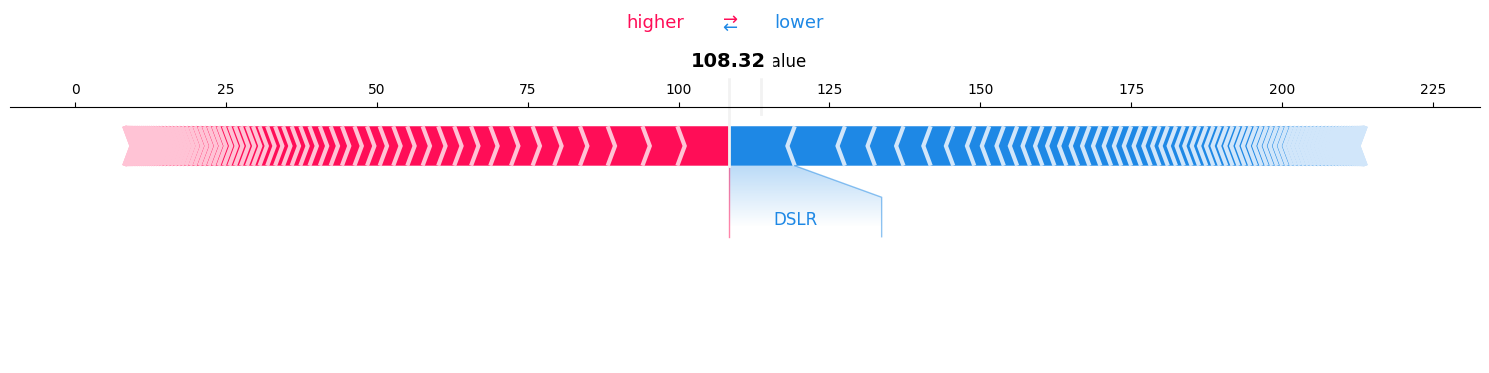

<Figure size 640x480 with 0 Axes>

In [14]:
# Compute standard Shapley values
explainer_sv = shapiq.TabularExplainer(
    model=hgbm_final,
    data=X_lisbon_q1,
    index="SV",
)

sv_values = explainer_sv.explain(x_explain, budget=256)
print("Top 10 Feature Attributions:")
print(sv_values)

# Force plot visualization
sv_values.plot_force(feature_names=feature_names)
plt.tight_layout()
plt.show()

### 2. Shapley Interaction Index (k-SII): Feature Synergies

**What it shows**: Which feature pairs interact synergistically or antagonistically.

**Notation**:
- `(i,)` = main effect of feature i (same as Shapley value)
- `(i, j)` = interaction between features i and j
  - **Positive** = synergy (together they boost price more than individually)
  - **Negative** = substitution (together they suppress each other's effect)

In [15]:
# Compute pairwise interactions for HGBM
explainer_sii = shapiq.TabularExplainer(
    model=hgbm_final,
    data=X_lisbon_q1,
    index="k-SII",
    max_order=2
)

sii_values = explainer_sii.explain(x_explain, budget=512)
print("Top 15 Interactions (HGBM):")
print(sii_values)

Top 15 Interactions (HGBM):
InteractionValues(
    index=k-SII, max_order=2, min_order=0, estimated=True, estimation_budget=408,
    n_players=147, baseline_value=113.68738291005238,
    Top 10 interactions:
        (): 113.68738291005238
        (31,): 12.145316245987821
        (88,): 12.145316245987821
        (32,): 11.071378775132345
        (106,): 11.071378775132345
        (9,): 7.738064319459037
        (29,): 6.974313688425163
        (32, 106): -11.071378775132345
        (18,): -11.992194881140666
        (31, 88): -12.145316245987821
)


### 3. Network Visualization: See the Interaction Structure

**How to read this plot**:
- **Nodes** = features
  - Size = importance of individual feature
  - Color intensity = magnitude of main effect
- **Edges** = interactions between features
  - Thickness = strength of interaction
  - Red/Pink = positive synergy
  - Blue = negative interaction

**What to look for**:
- Clusters of connected features (they work together)
- Strong edges (thick lines) = important feature combinations
- Isolated nodes = features that work independently

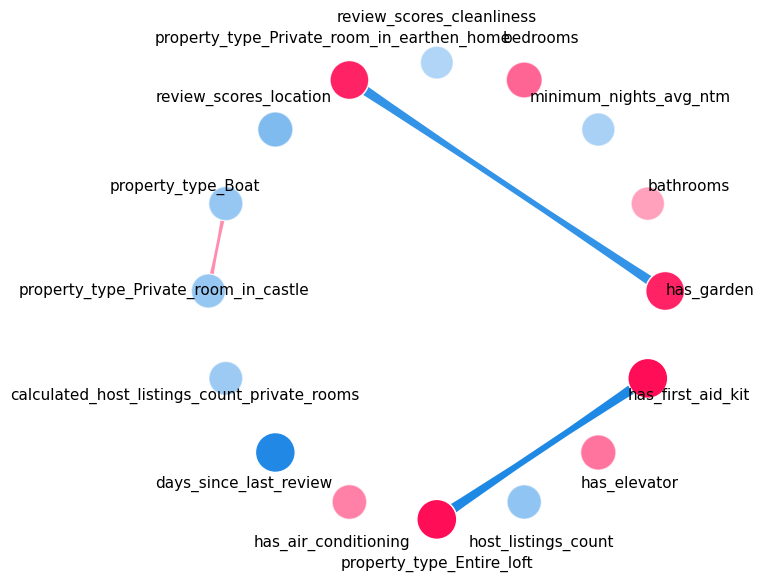

<Figure size 640x480 with 0 Axes>


=== Key Questions to Explore ===
• Do bedrooms, bathrooms, accommodates form a cluster? (size synergy)
• Which amenities interact with property size?
• Do room_type variables interact with location scores?
• What's the strongest interaction (thickest edge)?


In [19]:
# Network plot uses the full InteractionValues object (not just order 2)
# It automatically extracts both main effects and interactions
sii_values.plot_network(feature_names=feature_names)
# plt.title("Feature Interaction Network (HGBM)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== Key Questions to Explore ===")
print("• Do bedrooms, bathrooms, accommodates form a cluster? (size synergy)")
print("• Which amenities interact with property size?")
print("• Do room_type variables interact with location scores?")
print("• What's the strongest interaction (thickest edge)?")

### 4. Compare HGBM vs Random Forest Interactions

**Why this matters**: Different interaction patterns explain why models generalize differently across cities.

In [20]:
# Get Random Forest interactions
explainer_rf = shapiq.TabularExplainer(
    model=rf_final,
    data=X_lisbon_q1,
    index="k-SII",
    max_order=2
)

sii_rf = explainer_rf.explain(x_explain, budget=512)
print("Top 15 Interactions (Random Forest):")
print(sii_rf)

Top 15 Interactions (Random Forest):
InteractionValues(
    index=k-SII, max_order=2, min_order=0, estimated=True, estimation_budget=408,
    n_players=147, baseline_value=114.69375664316469,
    Top 10 interactions:
        (): 114.69375664316469
        (7,): 8.128564861457345
        (1,): 3.895457228662886
        (145,): 3.731199124457253
        (8,): 3.3307876410332056
        (9,): 3.062737582344056
        (140,): -3.2523620238134536
        (74,): -3.4140481728208774
        (15,): -4.173775217683715
        (18,): -4.3884720986037875
)


### 5. Extract and Compare Top Pairwise Interactions

**Method**: Filter to only 2-way interactions and rank by absolute strength.

In [21]:
# Extract only pairwise interactions (exclude main effects)
# The InteractionValues object stores interactions as a dictionary internally
hgbm_dict = {}
rf_dict = {}

# Iterate through all interactions in sii_values
# Each interaction is stored with its feature tuple as key
for interaction_tuple in sii_values.interaction_lookup:
    # Only keep 2-way interactions (length 2)
    if len(interaction_tuple) == 2:
        value = sii_values[interaction_tuple]
        hgbm_dict[interaction_tuple] = value

for interaction_tuple in sii_rf.interaction_lookup:
    if len(interaction_tuple) == 2:
        value = sii_rf[interaction_tuple]
        rf_dict[interaction_tuple] = value

# Convert to Series for ranking
hgbm_series = pd.Series(hgbm_dict)
rf_series = pd.Series(rf_dict)

# Get top 10 by absolute value
top_n = 10
hgbm_top = hgbm_series.abs().nlargest(top_n)
rf_top = rf_series.abs().nlargest(top_n)

print("="*95)
print("HGBM: Top 10 Pairwise Interactions".center(95))
print("="*95)
for idx in hgbm_top.index:
    feat1, feat2 = feature_names[idx[0]], feature_names[idx[1]]
    value = hgbm_series[idx]
    direction = "✓ synergy" if value > 0 else "✗ substitution"
    print(f"{feat1[:32]:32s} × {feat2[:32]:32s}: {value:8.3f}  {direction}")

print("\n" + "="*95)
print("Random Forest: Top 10 Pairwise Interactions".center(95))
print("="*95)
for idx in rf_top.index:
    feat1, feat2 = feature_names[idx[0]], feature_names[idx[1]]
    value = rf_series[idx]
    direction = "✓ synergy" if value > 0 else "✗ substitution"
    print(f"{feat1[:32]:32s} × {feat2[:32]:32s}: {value:8.3f}  {direction}")

                               HGBM: Top 10 Pairwise Interactions                              
has_first_aid_kit                × property_type_Entire_loft       :  -12.145  ✗ substitution
has_garden                       × property_type_Private_room_in_ea:  -11.071  ✗ substitution
property_type_Boat               × property_type_Private_room_in_ca:    5.700  ✓ synergy

                          Random Forest: Top 10 Pairwise Interactions                          
bedrooms_per_person              × maximum_nights                  :   -2.605  ✗ substitution


### Interpretation Guide: What These Results Tell Us

#### 1. Property Size Synergies
**Look for**: `bathrooms × bedrooms`, `accommodates × bathrooms`, `bedrooms × accommodates`

**If positive (synergy)**: Larger properties are worth MORE than the sum of their parts. A 3-bed, 2-bath place commands a premium beyond just "3 bedrooms + 2 bathrooms".

**Business insight**: Upgrading both bedrooms AND bathrooms together yields higher returns than upgrading them separately.

---

#### 2. Location × Amenity Interactions
**Look for**: `review_scores_location × has_elevator`, location scores × room features

**If positive**: Certain amenities are MORE valuable in well-located areas (e.g., elevator matters more in touristy centers).

**If negative**: Some features are substitutes (e.g., good location compensates for lack of elevator).

---

#### 3. Room Type Interactions
**Look for**: `room_type_Private_room × bathrooms`, `room_type_Entire_home × accommodates`

**Expected pattern**: Private rooms should show WEAK or NEGATIVE interactions with size features (extra bathrooms don't help much if guests share the space).

**Entire homes** should show STRONG POSITIVE interactions with size (more space = disproportionately valuable).

---

#### 4. Model Comparison: Why HGBM Generalizes Better

**If HGBM relies on universal interactions** (size × size, amenities × accommodates):
- These patterns transfer well to Porto
- Less dependent on city-specific neighborhoods

**If RF relies on location-specific interactions** (neighborhood × amenities):
- These don't transfer to Porto (different neighborhoods)
- Explains larger performance drop

**Check**: Are HGBM's top interactions more "universal" than RF's?

---

#### Practical Applications

1. **Feature Engineering**: Create explicit interaction terms for top synergies
   - `bedrooms_x_bathrooms = bedrooms * bathrooms`
   - May improve simpler models (OLS, Lasso)

2. **Pricing Strategy**: "Adding a 2nd bathroom is worth €50 in a studio, but €120 in a 3-bedroom"

3. **Model Selection**: Tree models capture these interactions automatically; linear models need manual feature crosses

4. **Generalization**: Models using "universal" interactions (size, amenities) transfer better than those using location-specific ones

